In [1]:
import math
import numpy as np
import pandas as pd
# this gives us the data scaling we want to use on features
# which we generally want to scale between 1 and -1
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load files with pandas
euro = pd.read_csv('euroFREDcsv.csv', usecols=[0,1])
spx = pd.read_csv('sp500FREDcsv.csv', usecols=[0,1])
yen = pd.read_csv('yenFREDcsv.csv', usecols=[0,1])

In [3]:
# put column names on the data
euro.columns = ['Date','Price']
spx.columns = ['Date','Price']
yen.columns = ['Date','Price']
# get rid of non-zero values
euroclean = euro[euro['Price'] > 0]
spxclean = spx[spx['Price'] > 0]
yenclean = yen[yen['Price'] > 0]
# create an array ("datearray") of dates where there is overlap
datearray = np.intersect1d(euroclean['Date'],spxclean['Date'])
datearray = np.intersect1d(datearray,yenclean['Date'])
datearray = pd.to_datetime(datearray)

In [4]:
# recast the data column as a datetime object
yenclean['Date'] = pd.to_datetime(yenclean['Date'])
euroclean['Date'] = pd.to_datetime(euroclean['Date'])
spxclean['Date'] = pd.to_datetime(spxclean['Date'])
# re-index the series to the date
yenclean.index = pd.DatetimeIndex(yenclean['Date'])
euroclean.index = pd.DatetimeIndex(euroclean['Date'])
spxclean.index = pd.DatetimeIndex(spxclean['Date'])

In [5]:
# now get the values of the data corresponding to the datearray dates
# .ix returns values at locations where indices = to value in datearray
df = pd.DataFrame({"Euro":euroclean.ix[datearray]['Price'],"Yen":yenclean.ix[datearray]['Price'],"Spx":spxclean.ix[datearray]['Price']},index=datearray)

Populating the interactive namespace from numpy and matplotlib


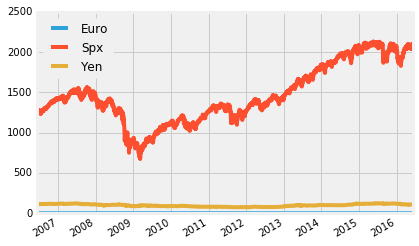

In [6]:
%pylab inline
df.plot()

In [7]:
# create %price change feature
df['Eurochg'] = df['Euro'].pct_change()
df['Yenchg'] = df['Yen'].pct_change()
df['Spxchg'] = df['Spx'].pct_change()
# create a dataframe to hold all the price changes
changes = pd.DataFrame({'Eurochg': df.ix[datearray]['Eurochg'],"Yenchg":df.ix[datearray]['Yenchg'],"Spxchg":df.ix[datearray]['Spxchg']},index=datearray)

In [8]:
# slice off the first row of df since incomplete data
df2 = df[1:]
df2[0:3]

,Euro,Spx,Yen,Eurochg,Yenchg,Spxchg
2006-06-09,1.2636,1252.30,113.89,-0.000949,-0.002889,-0.004476
2006-06-12,1.2587,1236.40,114.17,-0.003878,0.002459,-0.012697
2006-06-13,1.2574,1223.69,115.06,-0.001033,0.007795,-0.010280


### Basic Model Fitting
Create a **training set** and a **test** set

In [10]:
Y = df2['Spxchg']
X = (df2['Eurochg']-df2['Yenchg'])
half = int(floor(len(Y)/2))
train_X = X.iloc[:half]
train_Y = Y.iloc[:half]
test_X = X.iloc[half:]
test_Y = Y.iloc[half:]
# reshape the data
X_train_reshape = train_X[:,None]
X_test_reshape = test_X[:,None]
Y_train_reshape = train_Y[:,None]
Y_test_reshape = test_Y[:,None]

In [13]:
# create data offset for use in autocorrelation and prediction:
def createOffset(x,y,offset=1):
    # shifted_x = x[:len(x)-offset]
    shifted_x = x[:-offset]
    shifted_y = y[offset:]
    return shifted_x, shifted_y

### Identifying big moves

In [127]:
# get the original dataframe - before all the reshaping I guess?
df2[0:3]

,Euro,Spx,Yen,Eurochg,Yenchg,Spxchg,Eurorank,Yenrank,Spxrank
2006-06-09,1.2636,1252.30,113.89,-0.000949,-0.002889,-0.004476,1.0,2.0,3.0
2006-06-12,1.2587,1236.40,114.17,-0.003878,0.002459,-0.012697,2.0,1.0,3.0
2006-06-13,1.2574,1223.69,115.06,-0.001033,0.007795,-0.010280,2.0,1.0,3.0


In [128]:
# Let's just work with spx for now
# create new datatframe:
spx2 = spxclean.copy()
spx2[0:5]

,Date,Price
2006-06-08,2006-06-08,1257.93
2006-06-09,2006-06-09,1252.30
2006-06-12,2006-06-12,1236.40
2006-06-13,2006-06-13,1223.69
2006-06-14,2006-06-14,1230.04


In [129]:
# add 3 day, 5 day, 16 day and 39 day rolling pct change
spx2['chg3'] = spx2['Price'].pct_change(3)
spx2['chg5'] = spx2['Price'].pct_change(5)
spx2['chg16'] = spx2['Price'].pct_change(16)
spx2['chg39'] = spx2['Price'].pct_change(39)
spx2[39:45]

,Date,Price,chg3,chg5,chg16,chg39
2006-08-03,2006-08-03,1280.27,0.002828,0.013513,0.017218,0.017759
2006-08-04,2006-08-04,1279.36,0.006641,0.000634,0.029840,0.021608
2006-08-07,2006-08-07,1275.77,-0.002174,-0.000697,0.032009,0.031842
2006-08-08,2006-08-08,1271.48,-0.006866,0.000441,0.029964,0.039054
2006-08-09,2006-08-09,1265.95,-0.010482,-0.009855,0.023519,0.029194
2006-08-10,2006-08-10,1271.81,-0.003104,-0.006608,0.009525,0.012459


In [130]:
# identify mean and std of the pct change data
# I should probably write a function to iterate through but can't be bothered
chg3mean = spx2['chg3'].mean()
chg3std = spx2['chg3'].std()
chg5mean = spx2['chg5'].mean()
chg5std = spx2['chg5'].std()
chg16mean = spx2['chg16'].mean()
chg16std = spx2['chg16'].std()
chg39mean = spx2['chg39'].mean()
chg39std = spx2['chg39'].std()

In [131]:
spx_chg3_df = spx2['chg3']
spx_chg3_df = spx_chg3_df[3:]
spx_chg3_df[0:6]

2006-06-13   -0.027219
2006-06-14   -0.017775
2006-06-15    0.015982
2006-06-16    0.022759
2006-06-19    0.008211
2006-06-20   -0.012769
Name: chg3, dtype: float64

In [132]:
# Now create a dataframe with all of the biggest surges (up) and surges (down) along with their antecedents
def findBigMoves(df,stds=2.0):
    #takes input of %change as df
    results ={}
    avg = df.mean()
    sdv = df.std()
    for idx, item in enumerate(df):
        if abs(item) > (avg+(sdv*stds)):
            results[idx] = item
    return results

In [133]:
# now how do I get it to return the date as well?
bm3 = findBigMoves(spx_chg3_df,stds=5)
bm3

{584: -0.10594285098897938,
 585: -0.10397278094666262,
 586: -0.1390589370700831,
 601: 0.12388682090185177,
 616: -0.11555686159271228,
 619: 0.1394795598320131,
 620: 0.10955839156031644,
 691: 0.10969210530205609,
 1298: -0.11177936112477582}

In [ ]:
# plotting distribution of 3d %chg just for fun - is there a way
# to iterate through distributions to see which one matches the best?
# and is that a sensible idea?
spx2['chg3'].hist(bins=100)
plt.axvline(x=chg3mean+chg3std,linewidth=1) # +1 std
plt.axvline(x=chg3mean-chg3std,linewidth=1) # -1 std
plt.axvline(x=chg3mean+(chg3std*2),linewidth=3) # +2 std
plt.axvline(x=chg3mean-(chg3std*2),linewidth=3) # -2 std
xlim([-0.1,0.1])

In [89]:
# now that we can get the big moves, let's try and classify them...

## SVM Classification

In [ ]:
# need to massage the data into the right format?
X = ....
Y = ....

In [14]:
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, Y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, Y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, Y)
lin_svc = svm.LinearSVC(C=C).fit(X, Y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

ValueError: Unknown label type: 2006-06-09   -0.004476
2006-06-12   -0.012697
2006-06-13   -0.010280
2006-06-14    0.005189
2006-06-15    0.021235
2006-06-16   -0.003678
2006-06-19   -0.009109
2006-06-20   -0.000016
2006-06-21    0.009741
2006-06-22   -0.005271
2006-06-23   -0.000883
2006-06-26    0.004869
2006-06-27   -0.009084
2006-06-28    0.005487
2006-06-29    0.021565
2006-06-30   -0.002098
2006-07-03    0.007865
2006-07-05   -0.007249
2006-07-06    0.002494
2006-07-07   -0.006750
2006-07-10    0.001470
2006-07-11    0.004087
2006-07-12   -0.010939
2006-07-13   -0.012959
2006-07-14   -0.004902
2006-07-17   -0.001383
2006-07-18    0.001920
2006-07-19    0.018555
2006-07-20   -0.008477
2006-07-21   -0.007077
                ...   
2016-04-22    0.000048
2016-04-25   -0.001812
2016-04-26    0.001873
2016-04-27    0.001649
2016-04-28   -0.009231
2016-04-29   -0.005063
2016-05-02    0.007810
2016-05-03   -0.008677
2016-05-04   -0.005937
2016-05-05   -0.000239
2016-05-06    0.003175
2016-05-09    0.000753
2016-05-10    0.012484
2016-05-11   -0.009562
2016-05-12   -0.000170
2016-05-13   -0.008478
2016-05-16    0.009797
2016-05-17   -0.009411
2016-05-18    0.000205
2016-05-19   -0.003707
2016-05-20    0.006019
2016-05-23   -0.002085
2016-05-24    0.013681
2016-05-25    0.006975
2016-05-26   -0.000210
2016-05-27    0.004287
2016-05-31   -0.001000
2016-06-01    0.001130
2016-06-02    0.002825
2016-06-03   -0.002912
Name: Spxchg, dtype: float64